# Experiments
This notebook shows some experiments with the different implemented blocking and matching functions.

In [2]:
from erpub.pipeline.pipeline import Pipeline
from erpub.pipeline.preprocessing import all_lowercase_and_stripped
from erpub.pipeline.matching import jaccard_similarity, vector_embeddings, specific_name_matcher
from erpub.pipeline.blocking import naive_all_pairs, same_year_of_publication, author_names_initials
from experiment_utils import plot_blocking_comparison, evaluate_blocking_method, plot_matching_accs, get_accuracy_of_matches
import numpy as np

## Matching
We'll first look what matching functions are best. Therefore we'll look at the outputs of the different pipeline runs and compute and accuracy score based on `labeled_entities.csv`.

In [3]:

def run_matching_experiment(pipeline, name, thresholds, plot=True):
    accs = []
    for threshold in thresholds:
        pipeline.run(f"experiments/{name}_threshold_{threshold}", threshold)
        accs.append(get_accuracy_of_matches(f"experiments/{name}_threshold_{threshold}/matched_entities.csv"))
    if plot:
        plot_matching_accs(f"Matching accuracy of experiment: {name}", thresholds, accs)
    print(f"Matching accuracys: {accs}")


In [4]:
naive_thresholds = np.linspace(0.3, 0.9, num=5)
naive_thresholds


array([0.3 , 0.45, 0.6 , 0.75, 0.9 ])

### Default Pipeline

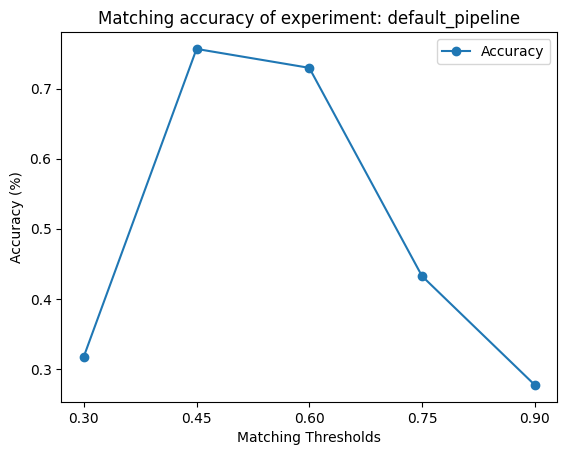

Matching accuracys: [0.31756756756756754, 0.7567567567567568, 0.7297297297297297, 0.43243243243243246, 0.27702702702702703]


In [5]:
pipeline = Pipeline(
    file_dir="data/prepared/",
    verbose=False,
)
run_matching_experiment(pipeline, "default_pipeline", naive_thresholds)


From this run it is already clear that we need to adjust the thresholds.

In [6]:
thresholds = np.linspace(0.5, 0.9, num=5)
thresholds


array([0.5, 0.6, 0.7, 0.8, 0.9])

### Skip publication_venues
Looking at the data in `data/prepared/` (you have to run the script in `erpub/data_preparation` initially) we can see that it might make sense to not match based on publication_venues.

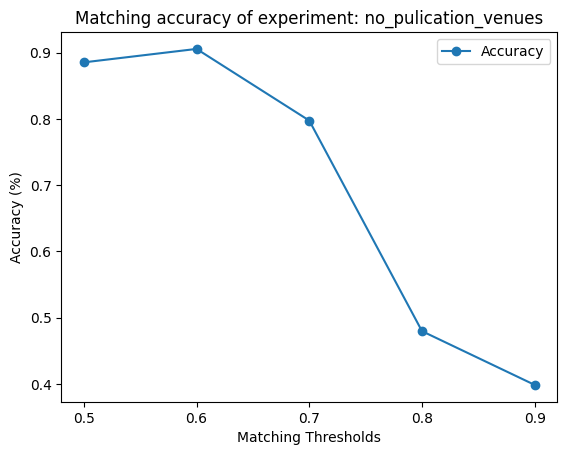

Matching accuracys: [0.8851351351351351, 0.9054054054054054, 0.7972972972972973, 0.4797297297297297, 0.39864864864864863]


In [7]:
pipeline = Pipeline(
    file_dir="data/prepared/",
    matching_fns={
        "paper_title": jaccard_similarity,
        "author_names": jaccard_similarity,
        "year_of_publication": jaccard_similarity,
    },
    verbose=False,
)
run_matching_experiment(pipeline, "no_pulication_venues", thresholds)


We can also introduce a equality_matcher for the attribute **year_of_publication** that behaves exactly the same as `jaccard_similarity`.

In [8]:
def equality_matcher(a, b):
    return float(a == b)


We can also introduce a better matcher for names as their structure is always the same.

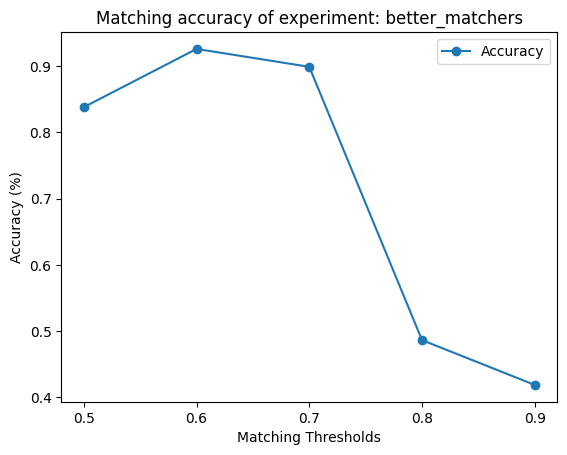

Matching accuracys: [0.8378378378378378, 0.9256756756756757, 0.8986486486486487, 0.4864864864864865, 0.4189189189189189]


In [9]:
pipeline = Pipeline(
    file_dir="data/prepared/",
    matching_fns={
        "paper_title": jaccard_similarity,
        "author_names": specific_name_matcher,
        "year_of_publication": equality_matcher,
    },
    verbose=False,
)
run_matching_experiment(pipeline, "better_matchers", thresholds)


### Add simple preprocessing

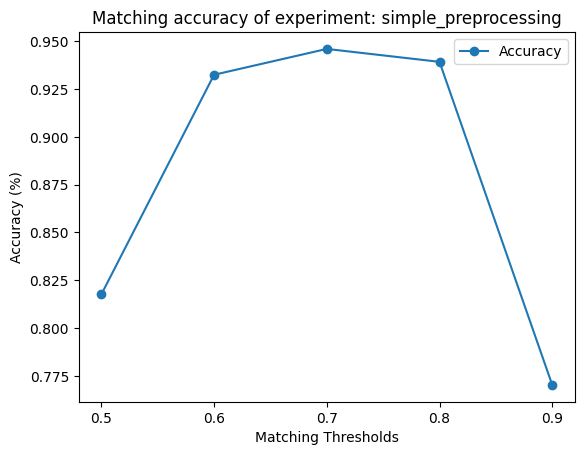

Matching accuracys: [0.8175675675675675, 0.9324324324324325, 0.9459459459459459, 0.9391891891891891, 0.7702702702702703]


In [10]:
pipeline = Pipeline(
    file_dir="data/prepared/",
    preprocess_data_fn=lambda df: df.map(lambda x: x.lower()),  # all lowercase
    matching_fns={
        "paper_title": jaccard_similarity,
        "author_names": specific_name_matcher,
        "year_of_publication": equality_matcher,
    },
    verbose=False,
)
run_matching_experiment(pipeline, "simple_preprocessing", thresholds)


### More advanced preprocessing
See `all_lowercase_and_strip` in `erpub.pipeline.preprocessing`.

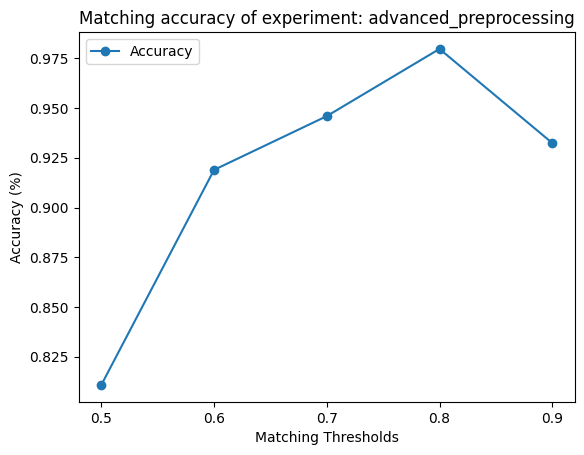

Matching accuracys: [0.8108108108108109, 0.918918918918919, 0.9459459459459459, 0.9797297297297297, 0.9324324324324325]


In [11]:
pipeline = Pipeline(
    file_dir="data/prepared/",
    preprocess_data_fn=all_lowercase_and_stripped,
    matching_fns={
        "paper_title": jaccard_similarity,
        "author_names": specific_name_matcher,
        "year_of_publication": equality_matcher,
    },
    verbose=False,
)
run_matching_experiment(pipeline, "advanced_preprocessing", thresholds)


### Without years

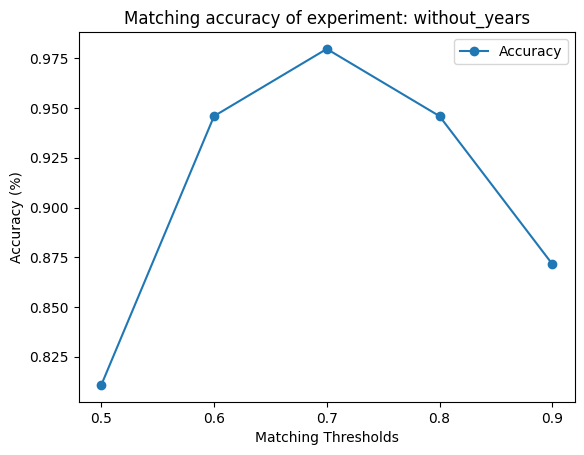

Matching accuracys: [0.8108108108108109, 0.9459459459459459, 0.9797297297297297, 0.9459459459459459, 0.8716216216216216]


In [12]:
pipeline = Pipeline(
    file_dir="data/prepared/",
    preprocess_data_fn=all_lowercase_and_stripped,
    matching_fns={"paper_title": jaccard_similarity, "author_names": specific_name_matcher},
    verbose=False,
)
run_matching_experiment(pipeline, "without_years", thresholds)


### With vector embeddings

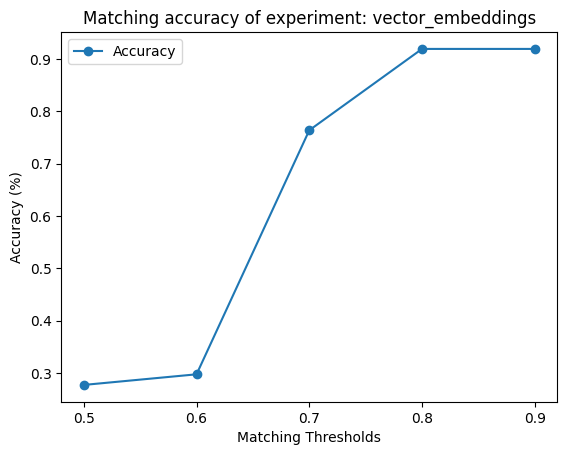

Matching accuracys: [0.27702702702702703, 0.2972972972972973, 0.7635135135135135, 0.918918918918919, 0.918918918918919]


In [13]:
pipeline = Pipeline(
    file_dir="data/prepared/",
    preprocess_data_fn=all_lowercase_and_stripped,
    matching_fns={
        "paper_title": vector_embeddings,
        "author_names": specific_name_matcher,
        "year_of_publication": equality_matcher,
    },
    embeddings_for_matching="embeddings/glove.6B.50d.txt",
    verbose=False,
)
run_matching_experiment(pipeline, "vector_embeddings", thresholds)


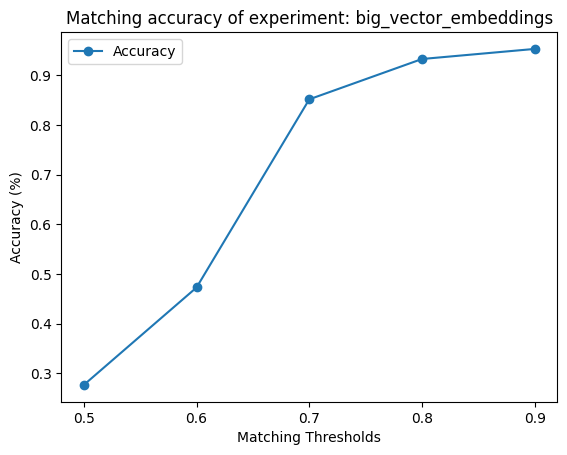

Matching accuracys: [0.27702702702702703, 0.47297297297297297, 0.8513513513513513, 0.9324324324324325, 0.9527027027027027]


In [14]:
pipeline = Pipeline(
    file_dir="data/prepared/",
    preprocess_data_fn=all_lowercase_and_stripped,
    matching_fns={
        "paper_title": vector_embeddings,
        "author_names": specific_name_matcher,
        "year_of_publication": equality_matcher,
    },
    embeddings_for_matching="embeddings/glove.6B.300d.txt",
    verbose=False,
)
run_matching_experiment(pipeline, "big_vector_embeddings", thresholds)


One can observe that `vector_embeddings` perform worse than the simple `jaccard_similarity`. The best matching occured therefore at the experiment **advanced_preprocessing** at an threshold of 0.8.

## Blocking
We now take at look how we can further improve this matching with introduction of blocking functions. For that we'll compare different blocking functions to the "baseline-function" `naive_all_pairs`.

In [15]:
def compare_to_baseline(blocking_fn, matching_fns, thresholds, plot=True):
    base_pipeline = Pipeline(
        file_dir="data/prepared/",
        preprocess_data_fn=all_lowercase_and_stripped,
        blocking_fn=naive_all_pairs,
        matching_fns=matching_fns,
        verbose=False,
    )
    experiment_pipeline = Pipeline(
        file_dir="data/prepared/",
        preprocess_data_fn=all_lowercase_and_stripped,
        blocking_fn=blocking_fn,
        matching_fns=matching_fns,
        verbose=False,
    )
    precisions, recalls, f1_scores = [], [], []
    baseline_times, experiment_times = [], []
    for threshold in thresholds:
        base_path = f"experiments/blocking_baseline_matching_jaccard/threshold_{threshold}"
        baseline_time = base_pipeline.run(dir_name=base_path, similarity_threshold=threshold)
        baseline_times.append(baseline_time)

        same_year_path = f"experiments/blocking_same_year_matching_jaccard/threshold_{threshold}"
        experiment_time = experiment_pipeline.run(dir_name=same_year_path, similarity_threshold=threshold)
        experiment_times.append(experiment_time)

        precision, recall, f1_score = evaluate_blocking_method(ground_truth=base_path, experiment=same_year_path)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)
    if plot:
        plot_blocking_comparison(
            f"Evaluation of blocking fucntion: {blocking_fn.__name__}",
            thresholds,
            precisions,
            recalls,
            f1_scores,
        )
    print(f"Baseline execution times: {baseline_times}")
    print(f"Experiment execution time: {experiment_times}")


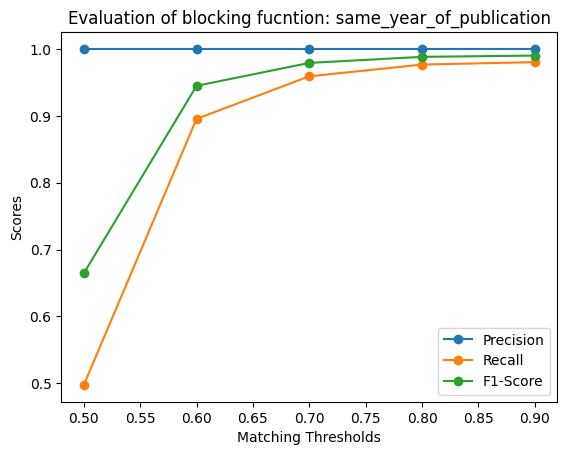

Baseline execution times: [47.58643460273743, 50.52614784240723, 52.17299294471741, 52.978487968444824, 51.33545398712158]
Experiment execution time: [5.289389133453369, 5.501555919647217, 5.53617787361145, 5.3929831981658936, 5.554837942123413]


In [16]:
compare_to_baseline(
    blocking_fn=same_year_of_publication,
    matching_fns={"paper_title": jaccard_similarity, "author_names": specific_name_matcher},
    thresholds=thresholds,
)


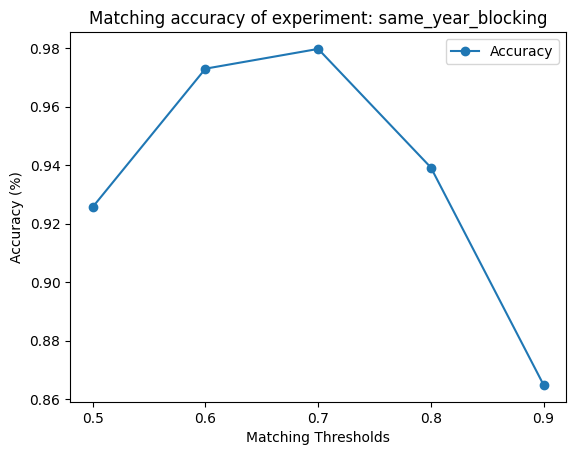

Matching accuracys: [0.9256756756756757, 0.972972972972973, 0.9797297297297297, 0.9391891891891891, 0.8648648648648649]


In [17]:
pipeline = Pipeline(
    file_dir="data/prepared/",
    preprocess_data_fn=all_lowercase_and_stripped,
    blocking_fn=same_year_of_publication,
    matching_fns={
        "paper_title": jaccard_similarity,
        "author_names": specific_name_matcher,
    },
    verbose=False,
)
run_matching_experiment(pipeline, "same_year_blocking", thresholds)

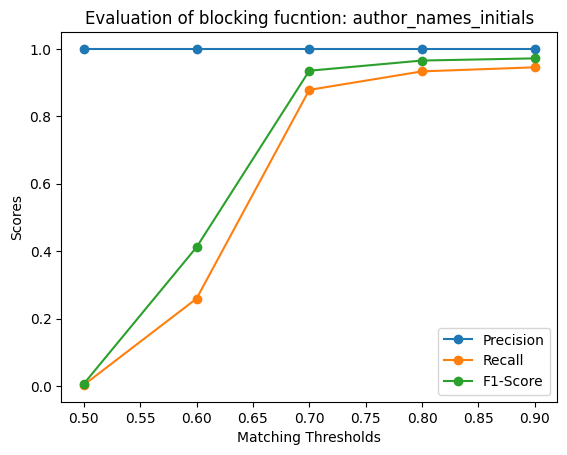

Baseline execution times: [21.96363401412964, 22.073588132858276, 21.747778177261353, 22.60600209236145, 22.457520008087158]
Experiment execution time: [0.913581132888794, 0.9201450347900391, 0.9464330673217773, 0.9127190113067627, 0.9613621234893799]


In [19]:
compare_to_baseline(
    blocking_fn=author_names_initials,
    matching_fns={"paper_title": jaccard_similarity, "year_of_publication": equality_matcher},
    thresholds=thresholds,
)


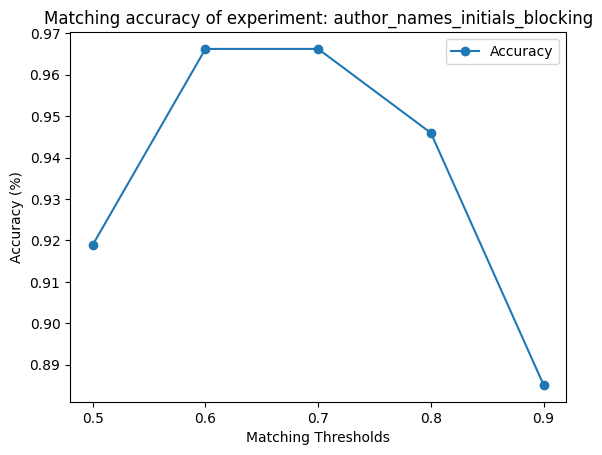

Matching accuracys: [0.918918918918919, 0.9662162162162162, 0.9662162162162162, 0.9459459459459459, 0.8851351351351351]


In [20]:
pipeline = Pipeline(
    file_dir="data/prepared/",
    preprocess_data_fn=all_lowercase_and_stripped,
    blocking_fn=author_names_initials,
    matching_fns={
        "paper_title": jaccard_similarity,
        "year_of_publication": equality_matcher,
    },
    verbose=False,
)
run_matching_experiment(pipeline, "author_names_initials_blocking", thresholds)

Finally it can be said that if you really value speed a good choise would be `author_names_initials`, as it's 20x faster than the baseline. On our labeled testset it performs slightly worse, whereas `same_year_of_publication` a higher accuracy and recall.